# Objective: To build a model for automatic ticket classification.
* For any service providing company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction and thus ultimately reduce reduce customer churn. This also provides an intuition to decision makers of how to improve their services to attract more customers. 
* These customer complaints are unstructured text data. so, traditionally, companies need to have dedicated team by investing not only in capital but also a lot of time for the task of evaluating and assigning each ticket to the relevant department with . This process becomes tedious and slow as the company grows and customer base gets larger.
* Our objective is to automate this process by creating a model that can automatically classify customer complaints based on the products and services that the ticket mentions.
* Since our data is text which is unstructured, we will take help of nlp.
* We will segment our task into two groups:
    * Topic modelling (Unsupervised learning): Since this data (i.e. Customer complaints) is not labelled, we need to do Topic modelling for finding latent themes/topics present in the corpora so that we can later map each ticket onto its respective department/category.
    * Text classification (supervised learning): After finding latent themes/topics present in the corpora we need to classify tickets into the following five clusters based on their products/services:
        * Credit card / Prepaid card
        * Bank account services
        * Theft/Dispute reporting
        * Mortgages/loans
        * Others 

## INDEX

* [Data loading](#Data-loading)
* [Text preprocessing](#Text-preprocessing)
* [Exploratory data analysis (EDA)](#Exploratory-data-analysis-(EDA))
* [Feature extraction](#Feature-extraction)
* [Topic modelling](#Topic-modelling)
* [Model building using supervised learning](#Model-building-using-supervised-learning)
* [Model training and evaluation](#Model-training-and-evaluation)
    * [Logistic regression](#Logistic-regression)
    * [Decision Tree](#Decision-Tree)
    * [Random Forest](#Random-Forest)
    * [Naive Bayes](#Naive-Bayes)
* [Model inference](#Model-inference)    
* [Conclusion](#Conclusion)

#### Importing the necessary libraries

In [1]:
# !pip install swifter    ## Installing swifter for reducing runtime.
# !python -m spacy download en_core_web_sm     ## Installing en_core_web_sm model from spacy module for nlp.

In [2]:
# Liabraries for general data processing:
import json 
import numpy as np
import pandas as pd
import swifter
import copy
from collections import Counter
from operator import itemgetter
import pickle

# Liabraries for nlp related data processing
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

# Liabraries for model training and metric evalution:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

# Liabraries for data visualization:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from plotly.offline import plot
# import plotly.graph_objects as go
# import plotly.express as px

In [4]:
def plot(df,n_gram):            # Function to plot top n-gram words with their frequency.
    sns.barplot(y='n_gram',x='frequency',data=df.head(10))
    plt.xticks(rotation=90)
    plt.ylabel(n_gram)
    plt.title(f'top 10 {n_gram}')
    plt.show()

## Data loading
The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Loading JSON file 
with open(r'C:\Users\ADMIN\Downloads\complaints-2021-05-14_08_16.json', 'r') as dataset:
    data = json.load(dataset)

# converting JSON file to a dataframe    
df=pd.json_normalize(data)

## Data preparation
Although other parts of email-body such as subject lines are also useful for email classification, We will primarily focus on main email content (i.e. complaint) in this case.

In [6]:
# Inspecting the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.shape

(78313, 22)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
#printing the column names:
print(f'Column names are as follow: \n{list(df.columns)}')

Column names are as follow: 
['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [10]:
#Assigning new column names which are easier to interpret:
df.rename(columns=lambda x: x.replace('_source.','').lstrip('_').replace('complaint_what_happened','complaints'), inplace=True)
print(f'Column names after renaming them are as follow: \n{list(df.columns)}')

Column names after renaming them are as follow: 
['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaints', 'sub_issue', 'consumer_consent_provided']


In [11]:
# Checking first 5 customer complaints:
list(df['complaints'][:5])

['',
 'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.',
 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.',
 '',
 '']

Although complaint column has no null values, it does have empty strings.

In [12]:
#Assigning nan in place of blanks in the complaints column:
df['complaints'] = df['complaints'].replace('^\s*$',np.nan, regex=True)

In [13]:
# Checking first 5 customer complaints:
list(df['complaints'][:5])

[nan,
 'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.',
 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.',
 nan,
 nan]

In [14]:
#Removing all rows where complaints column is nan as they do not provide any useful information:
df_filtered = df[df['complaints'].notnull()]['complaints'].copy(deep=True).to_frame()
df_filtered.reset_index(inplace=True,drop = True)
df_filtered.rename(columns={'complaints':'raw_complaints'},inplace=True)

In [15]:
# Creating filtered dataframe which do not contain any blank complaints:
df_filtered.head()

,raw_complaints
0,Good morning my name is XXXX XXXX and I apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,Chase Card was reported on XX/XX/2019. However...
3,"On XX/XX/2018, while trying to book a XXXX XX..."
4,my grand son give me check for {$1600.00} i de...


In [16]:
df_filtered.shape

(21072, 1)

In [17]:
# Again checking first 5 customer complaints after removal of blank complaints:
list(df_filtered['raw_complaints'][:5])

['Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.',
 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.',
 'Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtai

## Text preprocessing

Since our data is unstructred text, we need to perform certian Text preprocessing before feeding it to any model. Basically we try to reduce the noise in the data(e.g. removing punctuations) as well as standardize the format(e.g. making all words lower case).

We will perform following preprocessing steps:
* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.

In [18]:
# Function to clean the text and remove all the unnecessary elements.
def preprocessing(text):
    text = text.lower().replace('\n','')     # To make the text lowercase
    text = re.sub(r'\[[^\]]*\]','' ,text)    # To remove text in square brackets
    text = text.translate(str.maketrans("","", string.punctuation))  # To remove punctuation
    text = re.sub(r'\w*\d\w*','',text)                  # To remove words containing numbers
    return text

In [19]:
# We will also filter out common stop words as they will not provide any useful information for our task.
stop_words = stopwords.words('english')

In [20]:
# Function to filter out the stop words and then lemmatize the remaining text:
def lemmatize(text):
    text = nlp(text)
    text = [token.lemma_ for token in text if token.text not in stop_words]
    return " ".join(text)

In [21]:
df_filtered['processed_complaints'] = df_filtered['raw_complaints'].swifter.apply(preprocessing)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [22]:
df_filtered['lemmatized_complaints'] = df_filtered['processed_complaints'].swifter.apply(lemmatize)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [23]:
df_filtered.head()

,raw_complaints,processed_complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card tell agent upgrade an...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applica...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...


In [24]:
 # We will keep words that have 'NOUN' as POS
def pos_tag(text):   # Function to extract words having 'NOUN' POS tags
    text = nlp(text)
    text = [token.lemma_ for token in text if (token.pos_=="NOUN")]
    return " ".join(text)

In [25]:
df_filtered['POS_removed'] = df_filtered['lemmatized_complaints'].swifter.apply(pos_tag)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
df_filtered.head()

,raw_complaints,processed_complaints,lemmatized_complaints,POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx appreciate service chase deb...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgrade xxxx xxxx card tell agent upgrade an...,xxxx card agent upgrade anniversary date agent...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applica...,application submit identity consent service ex...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across of...,xxxx ticket offer ticket card information offe...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son account money son money money time call ve...


In [27]:
#Making new clean dataframe which contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = df_filtered[['raw_complaints','lemmatized_complaints','POS_removed']].copy(deep=True)

In [28]:
df_clean.shape

(21072, 3)

## Exploratory data analysis (EDA)

For EDA part we will be:
*   Visualizing the data according to the 'Complaint' character length
*   Visualizing top 40 words by frequency among all the articles after processing the text Using a word cloud
*   Visualizing top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

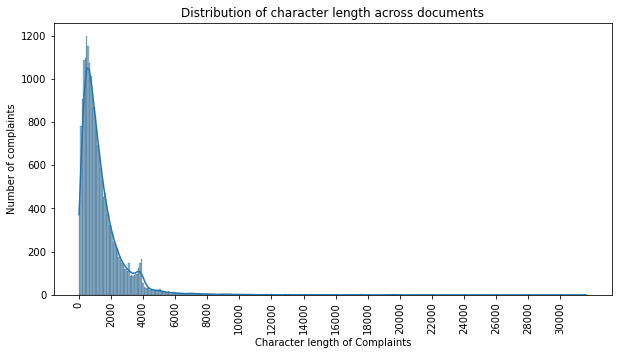

In [29]:
# For visualise the data according to the 'Complaint' character length
char_len = [len(doc) for doc in df_clean.raw_complaints]
plt.figure(figsize=(10,5))
sns.histplot(char_len,kde=True)
plt.xticks(np.arange(0, max(char_len)+1,2000),rotation=90)
plt.ylabel('Number of complaints')
plt.xlabel('Character length of Complaints')
plt.title('Distribution of character length across documents')
plt.show()

We roughly have a normal distribution which is skewed positively.

In [30]:
# Checking quantile summary characters length:
print(f"0th quantile of character length of complaints is { int(np.quantile(char_len, 0))} characters.") 
print(f"25th quantile of character length of complaints is { int(np.quantile(char_len, .25))} characters.") 
print(f"50th quantile of character length of complaints is { int(np.quantile(char_len, .5))} characters.") 
print(f"75th quantile of character length of complaints is { int(np.quantile(char_len, .75))} characters.")
print(f"100th quantile of character length of complaints is { int(np.quantile(char_len, 1))} characters.") 

0th quantile of character length of complaints is 19 characters.
25th quantile of character length of complaints is 528 characters.
50th quantile of character length of complaints is 983 characters.
75th quantile of character length of complaints is 1738 characters.
100th quantile of character length of complaints is 31611 characters.


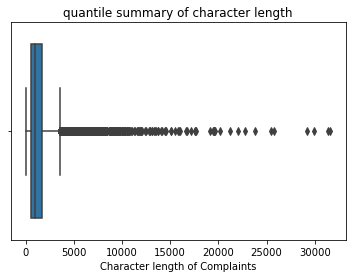

In [31]:
# Visualizing the quantile summary characters length:
sns.boxplot(char_len)
plt.xlabel('Character length of Complaints')
plt.title('quantile summary of character length')
plt.show()

Now we will use a word cloud to display the top 40 words by frequency among all the articles.
* Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

In [32]:
def top_words(text,top_n=40):  # Function to find top 40 words by frequency among all the articles
    complaint_words = text.str.split().values.tolist()
    all_words = [word for complaint in complaint_words for word in complaint]
    top_words = nltk.FreqDist(all_words).most_common(top_n)
    return top_words

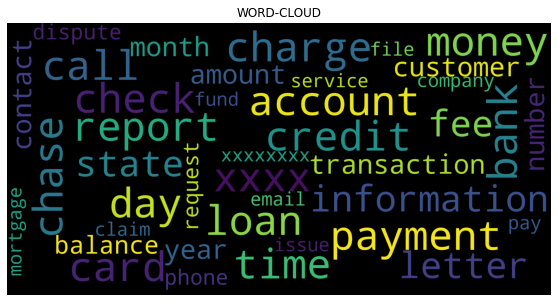

In [33]:
# plotting a word cloud to display the top 40 words by their frequency :
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color = 'black', width = 2000, height = 1000,
                      colormap = 'viridis', max_words = 40, contour_width = 3,
                      max_font_size = 150, contour_color = 'steelblue',
                      random_state = 0,collocations=False)
wordcloud.generate(' '.join([w for w,_ in top_words(df_clean.POS_removed)]))
plt.axis('off')
plt.imshow(wordcloud)
plt.title('WORD-CLOUD')
plt.show()

In [34]:
### Since we are using spacy version 3.2.1, there is no word '-PRON-' present in POS_removed complaint.
### For the sake of backword compatibility we will perform foloowing:
### Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [35]:
# Function to find the top 30 n-gram words w.r.t. frequency among the complaints in the cleaned datafram: 
def n_gram(text,n,max_features=30):
    vectorizer = CountVectorizer(ngram_range = (n,n),max_features=max_features)
    ngrams  = vectorizer.fit_transform(text) 
    count_values = ngrams.toarray().sum(axis=0)
    vocab = vectorizer.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'n_gram'})
    return df_ngram

# Df containing top 30 unigram by frequency:
df_unigram = n_gram(df_clean['Complaint_clean'],n=1,max_features=30)

In [36]:
# Top 10 unigram words w.r.t frequency are:
df_unigram.head(10)

,frequency,n_gram
0,56514,xxxx
1,44982,chase
2,42169,account
3,33834,credit
4,28222,card
5,21076,payment
6,18548,call
7,15776,time
8,15378,charge
9,12762,day


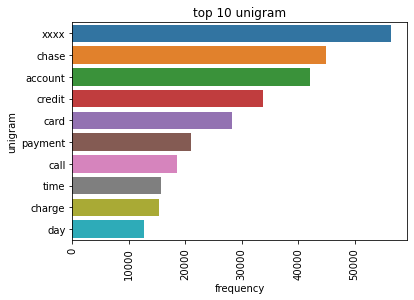

In [37]:
plot(df_unigram,'unigram')

In [38]:
## Df containing top 30 bigram words by frequency: 
df_bigram = n_gram(df_clean['Complaint_clean'],n=2,max_features=30)

In [39]:
# Top 10 bigram words w.r.t frequency are:
df_bigram.head(10)

,frequency,n_gram
0,12686,credit card
1,8851,xxxx xxxx
2,3935,credit report
3,3056,customer service
4,2374,chase credit
5,2112,call chase
6,1976,debit card
7,1939,contact chase
8,1825,account account
9,1717,account chase


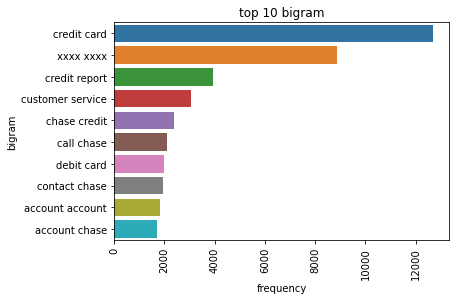

In [40]:
plot(df_bigram,'bigram')

In [41]:
## Df containing top 30 trigram words by frequency: 
df_trigram = n_gram(df_clean['Complaint_clean'],n=3,max_features=30)

In [42]:
# Top 10 trigram words w.r.t frequency are:
df_trigram.head(10)

,frequency,n_gram
0,1572,chase credit card
1,1409,xxxx xxxx xxxx
2,994,credit card account
3,969,credit card company
4,522,call customer service
5,521,xxxx credit card
6,490,credit card credit
7,489,credit card chase
8,459,credit card xxxx
9,453,inquiry credit report


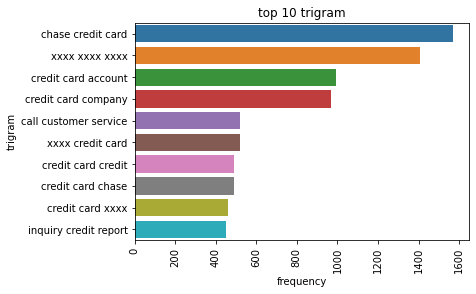

In [43]:
plot(df_trigram,'trigram')

The personal details of customer have been masked in the dataset with xxxx. we will remove the masked text as this will be of no use for our analysis.

In [44]:
def remove_X_pattern(text):  # Function to remove the masked text
    text = re.sub(r'\b([x] ?)+\b','' ,text)
    return text

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].swifter.apply(remove_X_pattern)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

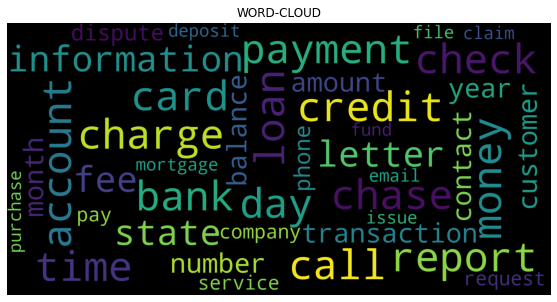

In [45]:
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color = 'black', width = 2000, height = 1000,
                      colormap = 'viridis', max_words = 40, contour_width = 3,
                      max_font_size = 150, contour_color = 'steelblue',
                      random_state = 0,collocations=False)
wordcloud.generate(' '.join([w for w,_ in top_words(df_clean['Complaint_clean'])]))
plt.axis('off')
plt.imshow(wordcloud)
plt.title('WORD-CLOUD')
plt.show()

In [46]:
#df_clean df after masked texts have been removed:
df_clean.head()

,raw_complaints,lemmatized_complaints,POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx appreciate service chase deb...,morning name appreciate service chase debt ver...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,xxxx card agent upgrade anniversary date agent...,card agent upgrade anniversary date agent info...
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applica...,application submit identity consent service ex...,application submit identity consent service ex...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come across of...,xxxx ticket offer ticket card information offe...,ticket offer ticket card information offer min...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account f...,son account money son money money time call ve...,son account money son money money time call ve...


## Feature extraction

Now we will Convert the raw texts to a matrix of TF-IDF features.For this we will use off the shelf TfidfVectorizer available in sklearn.feature_extraction.text module.
Following are the hyper-parameters that we will use:
* max_df : It is used for removing terms that appear too frequently, also known as "corpus-specific stop words". 
    * `max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"`
* min_df : it is used for removing terms that appear too rarely. 
    * `min_df = 2 means "ignore terms that appear in less than 2 documents".`
* stop_words : It is used to specify the list of words which are stop words that needs to be filtered. 
    * `stop_words = 'english' means 'ignore all the stop words specific to english language'.`
* ngram_range : It specifies the lower and upper boundary of the range of n-values for different n-grams to be extracted. 
    * `ngram_range=(1, 3) means "extract uni,bi and trigrams".`

In [47]:
#Write your code here to initialise the TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 3),
    stop_words='english',
)

Creating document term matrix using fit_transform:
* The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score.
The tuples that are not there have a tf-idf score of 0

In [48]:
DocTermMatrix= tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [49]:
len(tfidf_feature_names)

197406

In [50]:
## Inspecting DocTermMatrix :
# pd.DataFrame(DocTermMatrix.toarray(), columns=tfidf_feature_names).head()

## Topic modelling

* Since our data is unlabled, initially our task is of type unsupervised learning. By using Non-Negative Matrix Factorization (NMF) which is an unsupervised Topic modelling technique , we will first find latent topics in our dataset. 
* The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.
* We will have to find best number of such vector word clusters so that each group is unique and different from each other as much as possible. Then By inspecting & validating the correction of each cluster wrt the complaints, we need to Map/label the clusters to our desired topics/cluster names.

We will take help of coherence score to decide best number of topics.
* It is a measure of the degree of semantic similarity between high scoring words in the topic.
* in short,the coherence score measures how similar these words are to each other for given number topics.
* we want to maximize this coherence score.

In [51]:
# Using Gensim's NMF to get the best num of topics via coherence score:

complaints = df_clean['Complaint_clean']
complaints_words = [complaint.split() for complaint in complaints]

# Creating a dictionary : In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(complaints_words)

# Filtering out extremes to limit the number of features:
dictionary.filter_extremes(
    no_below=2,
    no_above=0.95,
)

In [52]:
# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(words) for words in complaints_words]

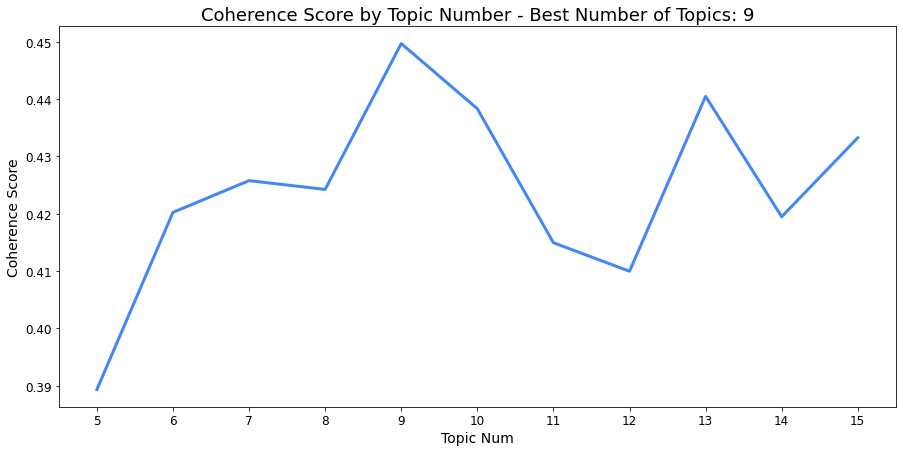

In [53]:
topic_nums = list(np.arange(5, 15 + 1, 1))

# Runing the nmf model and calculate the coherence score for each number of topics:
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=complaints_words,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Manual Topic Modeling
* At the end, coherence score is just an statistical method to measure the intra topic word similarity and may not always yield best number of topics for a given problem statement. 
* It must be noted that we must use domain knowledge for selecting best topic number as per our specific problem statement.

In [54]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40,max_iter=400)

In [55]:
Document_topic_mat = nmf_model.fit_transform(DocTermMatrix)  # Document-topic matrix
Topic_term_mat = nmf_model.components_       # Topic-term matrix

In [56]:
#Printing the Top15 words for each of the topics:
words = np.array(tfidf_feature_names)
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = Topic_term_mat[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words['latent_words']=topic_words.apply(lambda x: [','.join(x)], axis=1)

In [57]:
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,latent_words
Topic 0,account,check,money,deposit,bank,fund,chase,branch,day,transfer,number,account account,business,transaction,customer,"[account,check,money,deposit,bank,fund,chase,b..."
Topic 1,card,credit,credit card,chase,balance,chase credit,chase credit card,card credit,account,card account,score,limit,credit card account,credit score,credit card credit,"[card,credit,credit card,chase,balance,chase c..."
Topic 2,payment,loan,mortgage,chase,modification,home,month,year,time,pay,property,rate,payment payment,foreclosure,escrow,"[payment,loan,mortgage,chase,modification,home..."
Topic 3,inquiry,report,credit report,credit,inquiry credit,inquiry credit report,report credit,report inquiry,credit report credit,reporting,company,information,remove,credit report inquiry,credit reporting,"[inquiry,report,credit report,credit,inquiry c..."
Topic 4,charge,dispute,chase,transaction,merchant,fee,refund,purchase,claim,email,contact,fraud,service,time,company,"[charge,dispute,chase,transaction,merchant,fee..."


In [58]:
#Printing the Top15 words for each of the topics:
for index in topic_words.index:
    print(f'THE TOP 15 WORDS FOR {index}')
    print(topic_words.loc[index,'latent_words'][0])
    print('\n')

THE TOP 15 WORDS FOR Topic 0
account,check,money,deposit,bank,fund,chase,branch,day,transfer,number,account account,business,transaction,customer


THE TOP 15 WORDS FOR Topic 1
card,credit,credit card,chase,balance,chase credit,chase credit card,card credit,account,card account,score,limit,credit card account,credit score,credit card credit


THE TOP 15 WORDS FOR Topic 2
payment,loan,mortgage,chase,modification,home,month,year,time,pay,property,rate,payment payment,foreclosure,escrow


THE TOP 15 WORDS FOR Topic 3
inquiry,report,credit report,credit,inquiry credit,inquiry credit report,report credit,report inquiry,credit report credit,reporting,company,information,remove,credit report inquiry,credit reporting


THE TOP 15 WORDS FOR Topic 4
charge,dispute,chase,transaction,merchant,fee,refund,purchase,claim,email,contact,fraud,service,time,company




In [59]:
# Assigning the best topic to each of the cmplaints in Topic Column:
df_clean['Topic'] = Document_topic_mat.argmax(axis=1)

In [60]:
# Inspecting new Topic Column:
df_clean.head()

,raw_complaints,lemmatized_complaints,POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx appreciate service chase deb...,morning name appreciate service chase debt ver...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,xxxx card agent upgrade anniversary date agent...,card agent upgrade anniversary date agent info...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applica...,application submit identity consent service ex...,application submit identity consent service ex...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come across of...,xxxx ticket offer ticket card information offe...,ticket offer ticket card information offer min...,3
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account f...,son account money son money money time call ve...,son account money son money money time call ve...,0


In [61]:
# Printing the first 5 Complaint for each of the Topics:
pd.set_option('display.max_colwidth', None)

df_topic=df_clean.groupby('Topic').head(5)
df_topic[['raw_complaints','Topic']].sort_values('Topic')

,raw_complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
15,"I opened the saving account for the {$25.00} bonus. I was supposed to received the {$25.00} bonus after 3 consecutive auto transfers from checking to savings. I notice on XX/XX/2019 that automatic transfer was cancelled for not enough funds into my checking 's account. Therefore, I put enough funds in my account on XX/XX/2019 requested that the executive team reactivate my automatic transfer for the month of XXXX. Although Ms. XXXX reached out to me from the executive office, she failed to try to resolve my concerns ( case # XXXX ).",0
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. This situation is truly affecting my livelihood and they dont seem to want to deal with Me professionally. Thank you",0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0
12,"I opened an account with chase bank on XXXX and used a code for XXXX bonus. I called to follow up on XX/XX/XXXX about the terms and was told everything was on the accou

After evaluating the mapping, we will now assign following names/labels to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [62]:
#Creating the dictionary of Topic names and Topics:

Topic_names = {
    0 : 'Bank Account services',
    1 : 'Credit card or prepaid card',
    2 : "Mortgage/Loan",
    3 : 'Others',
    4: "Theft/Dispute Reporting"}

#Replacing Topics with Topic Names:
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [63]:
df_clean[['raw_complaints','Topic']].head()

,raw_complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Others
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",Others
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Bank Account services


## Model building using supervised learning
Our ultimate objective is to have automated email classification system.
* we will now start building classification models using supervised learning since we now have craeted labelled data.
* Since we will be using supervised learning technique we will have to convert the topic names to numbers(numpy arrays only understand numbers).

In [64]:
# Creating the dictionary again of Topic names and Topics:
Topic_names = {  
    'Bank Account services' : 0,
    'Credit card or prepaid card' : 1,
    'Theft/Dispute Reporting' : 2,
    'Mortgage/Loan' : 3,
    'Others' : 4
}

# Replacing Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [65]:
df_clean[['raw_complaints','Topic']].head()

,raw_complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",4
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",4
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0


In [66]:
# Keeping only the relevent columns i.e. "raw_complaints" & "Topic" in the new dataframe :
training_data=df_clean[['raw_complaints','Topic']].copy(deep=True)

In [67]:
training_data.head()

,raw_complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",4
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",4
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0


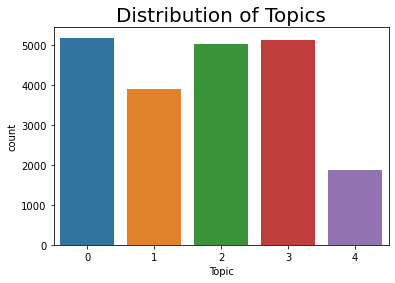

In [68]:
sns.countplot(data=training_data,x='Topic')
plt.title("Distribution of Topics", fontsize=20)
plt.show()

For model training, we need to prepere the data. For this we will perform following steps:
* Create the vector counts using Count Vectoriser.
    * ngram_range = (1,3) : We are using unigrams,bigrams and trigrams
    * stop_words='english' : We will filter common stop words specific to english language.
    * max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". 
        * max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints".
    * min_df is used for removing terms that appear rarely. 
        * min_df = 2 means "ignore terms that appear in less than 2 documents".
    * Since we have large number of features, we will make use of 'max_features'. 
        * max_features = 20000 means 'build a vocabulary that only considers the top 20000 features ordered by term frequency across the corpus'.
* Transform the word vecotr to tf-idf.
* Create the train & test data using the train_test_split on the tf-idf & topics.

In [69]:
X = training_data.raw_complaints.values
y = training_data.Topic.values

# Creating the vector counts using Count Vectoriser:
vectorizer = CountVectorizer(ngram_range = (1,3),stop_words='english',max_df=.95,min_df=2,max_features=20000)
X_count_vectorizer = vectorizer.fit_transform(X)

# Transforming the word vecotrs to tf-idf:
tf_idf_transform = TfidfTransformer()
X_tf_idf = tf_idf_transform.fit_transform(X_count_vectorizer)

# Create the train & test data using the train_test_split on the tf-idf & topics:
X_train,X_test,y_train,y_test = train_test_split(X_tf_idf,y,test_size=0.2,random_state=40)

In [70]:
# Saving vocab for inferencing on new content later:
with open('CountVec_pkl', 'wb') as files:
    pickle.dump(vectorizer, files)
    
with open('TfidfTransformer_pkl', 'wb') as files:
    pickle.dump(tf_idf_transform, files)

In [71]:
# Inspecting shape of train and test set:
print(f'Shape of X_train and X_test is {X_train.shape} , {X_test.shape} respectively')
print(f'Shape of y_train and y_test is {y_train.shape} , {y_test.shape} respectively')

Shape of X_train and X_test is (16857, 20000) , (4215, 20000) respectively
Shape of y_train and y_test is (16857,) , (4215,) respectively


## Model training and evaluation

In [72]:
X_train_copy = copy.deepcopy(X_train)
X_test_copy = copy.deepcopy(X_test)
y_train_copy = copy.deepcopy(y_train)
y_test_copy = copy.deepcopy(y_test)

#### Logistic regression :

In [73]:
X_train = copy.deepcopy(X_train_copy)
X_test = copy.deepcopy(X_test_copy)
y_train = copy.deepcopy(y_train_copy)
y_test = copy.deepcopy(y_test_copy)

In [74]:
logreg = LogisticRegression(random_state=40,max_iter=500)
logreg.fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_test)

# Metric evalution:
clf_report = classification_report(y_test,y_pred_logreg)
print(F'ACC : {accuracy_score(y_test,y_pred_logreg)}')
print(clf_report)

ACC : 0.9074733096085409
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1049
           1       0.90      0.89      0.89       777
           2       0.89      0.87      0.88      1009
           3       0.93      0.95      0.94      1013
           4       0.88      0.89      0.88       367

    accuracy                           0.91      4215
   macro avg       0.90      0.90      0.90      4215
weighted avg       0.91      0.91      0.91      4215



In [75]:
# Hyperparameter tuning to improve performance of the model:
param_grid_lr = {
     'penalty': ['l1', 'l2'],
     'C': [0.001,0.01,0.1,1,10,100],
     'solver':['liblinear', 'saga']
    }

grid_lr = GridSearchCV(estimator=logreg, 
                       param_grid=param_grid_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=4)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [76]:
logreg_tune=LogisticRegression(C=1, 
                               penalty='l1', 
                               solver='saga',max_iter=500,random_state=40)
logreg_tune.fit(X_train, y_train)
y_pred_lr = logreg_tune.predict(X_test)

# Metric evalution:
clf_report = classification_report(y_test,y_pred_lr)
print(F'ACC : {accuracy_score(y_test,y_pred_lr)}')
print(clf_report)

ACC : 0.9221826809015421
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1049
           1       0.92      0.92      0.92       777
           2       0.90      0.89      0.89      1009
           3       0.94      0.95      0.94      1013
           4       0.89      0.91      0.90       367

    accuracy                           0.92      4215
   macro avg       0.92      0.92      0.92      4215
weighted avg       0.92      0.92      0.92      4215



In [77]:
logreg_cm = confusion_matrix(y_test,y_pred_lr)
print(logreg_cm)

[[989  10  35  12   3]
 [ 10 714  33   6  14]
 [ 39  32 893  36   9]
 [ 14   7  20 958  14]
 [  4  13   8   9 333]]


In [78]:
with open('Logit_pkl', 'wb') as files:
    pickle.dump(logreg_tune, files)

#### Decision tree:

In [79]:
X_train = copy.deepcopy(X_train_copy)
X_test = copy.deepcopy(X_test_copy)
y_train = copy.deepcopy(y_train_copy)
y_test = copy.deepcopy(y_test_copy)

In [80]:
dt_clf=DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

# Metric evalution:
clf_report = classification_report(y_test,y_pred_dt)
print(F'ACC : {accuracy_score(y_test,y_pred_dt)}')
print(clf_report)

ACC : 0.7620403321470937
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1049
           1       0.77      0.77      0.77       777
           2       0.70      0.69      0.70      1009
           3       0.79      0.82      0.81      1013
           4       0.74      0.76      0.75       367

    accuracy                           0.76      4215
   macro avg       0.76      0.76      0.76      4215
weighted avg       0.76      0.76      0.76      4215



In [81]:
#  Hyperparameter tuning to improve decision tree performance
param_grid_dt = {'criterion': ['gini', 'entropy'],
                 'max_depth' : [15, 20, 25, 30],
                 'min_samples_leaf':[5,10,15,20],
                 'max_features':['auto','log2','sqrt',None] 
                }

grid_dt = GridSearchCV(estimator=dt_clf, 
                       param_grid=param_grid_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=4)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 4 folds for each of 128 candidates, totalling 512 fits
{'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 10}


In [82]:
dt_clf_tune=DecisionTreeClassifier(criterion='gini', max_depth= 25, max_features= None, min_samples_leaf= 10)
dt_clf_tune.fit(X_train, y_train)
y_pred_dt = dt_clf_tune.predict(X_test)

# Metric evalution:
clf_report = classification_report(y_test,y_pred_dt)
print(F'ACC : {accuracy_score(y_test,y_pred_dt)}')
print(clf_report)

ACC : 0.7772241992882563
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1049
           1       0.76      0.79      0.78       777
           2       0.71      0.71      0.71      1009
           3       0.85      0.82      0.83      1013
           4       0.76      0.69      0.73       367

    accuracy                           0.78      4215
   macro avg       0.77      0.77      0.77      4215
weighted avg       0.78      0.78      0.78      4215



In [83]:
DT_cm = confusion_matrix(y_test,y_pred_dt)
print(DT_cm)

[[861  34  99  44  11]
 [ 30 617  83  14  33]
 [131  81 713  66  18]
 [ 54  33  79 830  17]
 [ 15  45  28  24 255]]


#### Random Forest

In [84]:
X_train = copy.deepcopy(X_train_copy)
X_test = copy.deepcopy(X_test_copy)
y_train = copy.deepcopy(y_train_copy)
y_test = copy.deepcopy(y_test_copy)

In [85]:
rf = RandomForestClassifier(n_estimators= 50)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)


# Metric evalution:
clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.8453143534994069
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1049
           1       0.78      0.85      0.81       777
           2       0.85      0.75      0.80      1009
           3       0.89      0.89      0.89      1013
           4       0.88      0.81      0.85       367

    accuracy                           0.85      4215
   macro avg       0.85      0.84      0.84      4215
weighted avg       0.85      0.85      0.84      4215



In [86]:
# Hyperparameter tuning to improve performance of the model:
param_grid_rf = {
'n_estimators' : [50,100,125],# Number of trees in random forest
'max_depth' : [10,None], # Maximum number of levels in tree
'min_samples_split' : [2, 20],  # Minimum number of samples required to split a node
'min_samples_leaf' : [1, 20],    # Minimum number of samples required at each leaf node
'bootstrap' : [True, False]   # Method of selecting samples for training each tree
                }

grid_rf = GridSearchCV(estimator=rf, 
                       param_grid=param_grid_rf,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=4)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 125}


In [87]:
rf_clf_tune=RandomForestClassifier(bootstrap= True, max_depth= None, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 125)
rf_clf_tune.fit(X_train, y_train)
y_pred_rf = rf_clf_tune.predict(X_test)

# Metric evalution:
clf_report = classification_report(y_test,y_pred_rf)
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_report)

ACC : 0.8609727164887307
              precision    recall  f1-score   support

           0       0.86      0.92      0.88      1049
           1       0.80      0.87      0.83       777
           2       0.87      0.77      0.82      1009
           3       0.91      0.90      0.90      1013
           4       0.89      0.84      0.86       367

    accuracy                           0.86      4215
   macro avg       0.86      0.86      0.86      4215
weighted avg       0.86      0.86      0.86      4215



In [88]:
RF_cm = confusion_matrix(y_test,y_pred_rf)
print(RF_cm)

[[960  35  33  14   7]
 [ 19 676  62  11   9]
 [102  63 778  51  15]
 [ 35  44  18 907   9]
 [  5  31   5  18 308]]


#### Naive Bayes

In [89]:
X_train = copy.deepcopy(X_train_copy)
X_test = copy.deepcopy(X_test_copy)
y_train = copy.deepcopy(y_train_copy)
y_test = copy.deepcopy(y_test_copy)

In [90]:
NB = MultinomialNB()
NB.fit(X_train,y_train)

y_pred = NB.predict(X_test)

# Metric evalution:
clf_report = classification_report(y_test,y_pred)
print(F'ACC : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC : 0.7947805456702254
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1049
           1       0.74      0.68      0.71       777
           2       0.77      0.75      0.76      1009
           3       0.80      0.89      0.84      1013
           4       0.87      0.63      0.73       367

    accuracy                           0.79      4215
   macro avg       0.80      0.77      0.78      4215
weighted avg       0.80      0.79      0.79      4215



In [91]:
NB_cm = confusion_matrix(y_test,y_pred)
print(NB_cm)

[[930  36  41  35   7]
 [ 52 531 136  49   9]
 [ 92  56 759  89  13]
 [ 40  44  25 900   4]
 [  9  55  19  54 230]]


## We will go with the Logistic regression model since it is giving us the highest avg accuracy and F1 score.

#### Model inference

In [92]:
with open('Logit_pkl' , 'rb') as file:
    LogitModel = pickle.load(file)
    
with open('CountVec_pkl', 'rb') as file:
    CountVec = pickle.load(file)
    
with open('TfidfTransformer_pkl', 'rb') as file:
    TfidfTransformer = pickle.load(file)

In [93]:
def get_key(val):
    for key, value in Topic_names.items():
         if val == value:
             return key

In [94]:
sent1 = 'Fraudulent activity on my statement.I want to raise file case.'
sent2 = 'I want to add nominee to my savings account.'
sent3 = 'I want to apply for the loan amount of 10 million.'
sent4 = 'I want to get another credit card. My credit score is good.'
sent5 = "Please remove inquiries which are made by my significant other."

In [95]:
custom_complaints = { 'sent' : [sent1,sent2,sent3,sent4,sent5] }
custom_complaints_df = pd.DataFrame(custom_complaints)

In [96]:
custom_complaints_df

,sent
0,Fraudulent activity on my statement.I want to raise file case.
1,I want to add nominee to my savings account.
2,I want to apply for the loan amount of 10 million.
3,I want to get another credit card. My credit score is good.
4,Please remove inquiries which are made by my significant other.


In [97]:
def inference(text):
    sent_vect = CountVec.transform([text])
    sent_tfidf = TfidfTransformer.transform(sent_vect)
    sent_pred = LogitModel.predict(sent_tfidf)
    return get_key(sent_pred)

In [98]:
custom_complaints_df['prediction'] = custom_complaints_df.sent.apply(inference)

In [99]:
custom_complaints_df

,sent,prediction
0,Fraudulent activity on my statement.I want to raise file case.,Theft/Dispute Reporting
1,I want to add nominee to my savings account.,Bank Account services
2,I want to apply for the loan amount of 10 million.,Mortgage/Loan
3,I want to get another credit card. My credit score is good.,Credit card or prepaid card
4,Please remove inquiries which are made by my significant other.,Others


## Conclusion
* We have performed topic modelling to get latent themes from the data.
* After getting latent topics we grouped and labelled the data to desired classes which can be then used for classification.
* We acknowldge that there is a lot more scope for further improvement with more detailed preprocessing and feature extraction and hyperparameter tuning. 
* We can also use models such as LDA or PLSA for topic modelling which are more popular.

In [100]:
print('Done')

Done
